In [1]:
# Define colors
Pitt.Blue<- "#003594"
Pitt.Gold<-"#FFB81C"
Pitt.DGray <- "#75787B"
Pitt.Gray <- "#97999B"
Pitt.LGray <- "#C8C9C7"
# ggplot preferences
library("ggplot2")
library("repr")
options(repr.plot.width=10, repr.plot.height=10/1.68)
Pitt.Theme<-theme( panel.background = element_rect(fill = "white", linewidth = 0.5, linetype = "solid"),
  panel.grid.major = element_line(linewidth = 0.5, linetype = 'solid', colour =Pitt.Gray), 
  panel.grid.minor = element_line(linewidth = 0.25, linetype = 'solid', colour = "white")
  )
base<- ggplot() +aes()+ Pitt.Theme

# Non-linear Least Squares and Quantile regression

In some setting, the standard linear model might fail to give us the relationship we want:

OLS model estimations have us try to get a sense of:
* Constant marginal effects for each variable 
    - i.e linear in the parameters $\beta_0$,  $\beta_1$, $\ldots$, $\beta_k$
* The expected relationship in the population
    - i.e we are trying to understand the effects on the *average* person

Here I'll discuss two estimation methods that allow us to move beyond this:
* Non-linear Least Squares (NLS)
    - this method will allow us to specify relationships where the parameters enter non-linearly
    - for example, via ratios, interactions, etc. 

* Quantile regression
    - this method will allow us to switch to predicting a *quantile* for the population
    - for example, the median, the top 10 percent, etc.

* In each case, the model means that we will not have a nice closed-form solution as in OLS
* As such, we're going to have to find the optimal parameters using some numerical methods

We'll go through both methods today:
* We'll talk about the objectives that are maximized
* We'll set-up and use optimizer to search for good solutions
* And finally, we'll look at the libraries in R that can run these estimations for us

## Non-linear least squares:
The set-up is very similar to ordinary least squares:
* We have an outcome $y_i$ we are seeking to explain
* We have a series of $k$ different explanatory variables, $\mathbf{x}_i=\left(x_{i,1}, x_{i,2},\ldots, x_{i,k}\right)$

Similar to OLS we are trying to estimate the conditional expectation of $y$ given the observables $\mathbf{x}_i$. 

However we now specify that this conditional mean has a non-linear relationship:
$\mathbb{E}(y|\mathbf{x})=f(\mathbf{x})$
where the function $f(\cdot)$ has j unknown parameters $\boldsymbol{\beta}=(\beta_0, \beta_1,\ldots, \beta_j)$.

Again, similar to OLS, we specify that there is an *additive* error $\epsilon_i$ for each observation such that the realized $y_i$ satisfies:
$$ y_i=f(\mathbf{x};\boldsymbol{\beta})+\epsilon_i$$
where $\epsilon_i$ is a mean zero disturbance with variance $\sigma^2$

As an example, suppose we are trying to estimate the growth of a user-base across time $t$.

We want to fit the data to a logistic function 
 $$ f(t)=\frac{\alpha}{1+\gamma \exp(-\lambda t)}$$

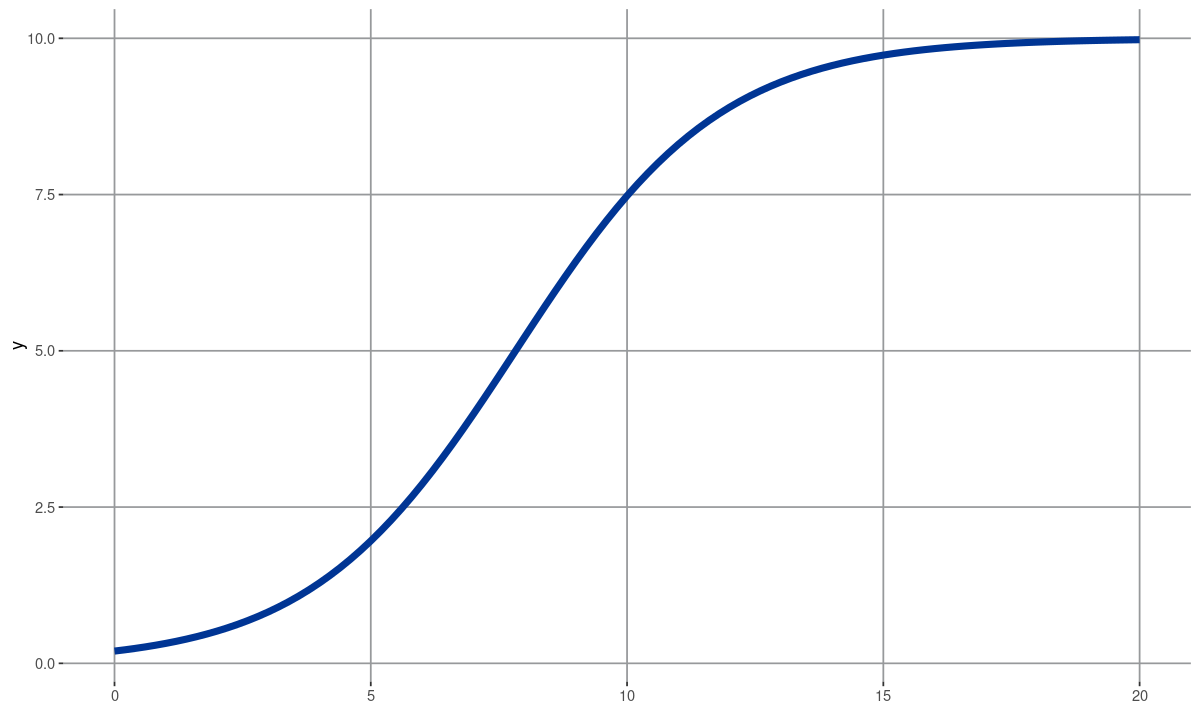

In [8]:
logis.f<-function(t,alpha,gamma,lambda) alpha/(1+gamma*exp(-lambda *t))
base+stat_function( fun=logis.f,args=list(alpha = 10, gamma =50, lambda=1/2), color=Pitt.Blue,linewidth=2)+ xlim(0,20)

So this is a function that allows for a slow initial growth, a period of quick growth, then a levelling off.

So we'll use this to model the growth of active Twitter users in the US (source: public Twitter account, before takeover and rebranding to X)

,year,q,TwitterActiveUS,t
,<int>,<int>,<int>,<int>
32,2017,4,68,32
33,2018,1,69,33
34,2018,2,68,34
35,2018,3,67,35
36,2018,4,66,36
37,2019,1,68,37


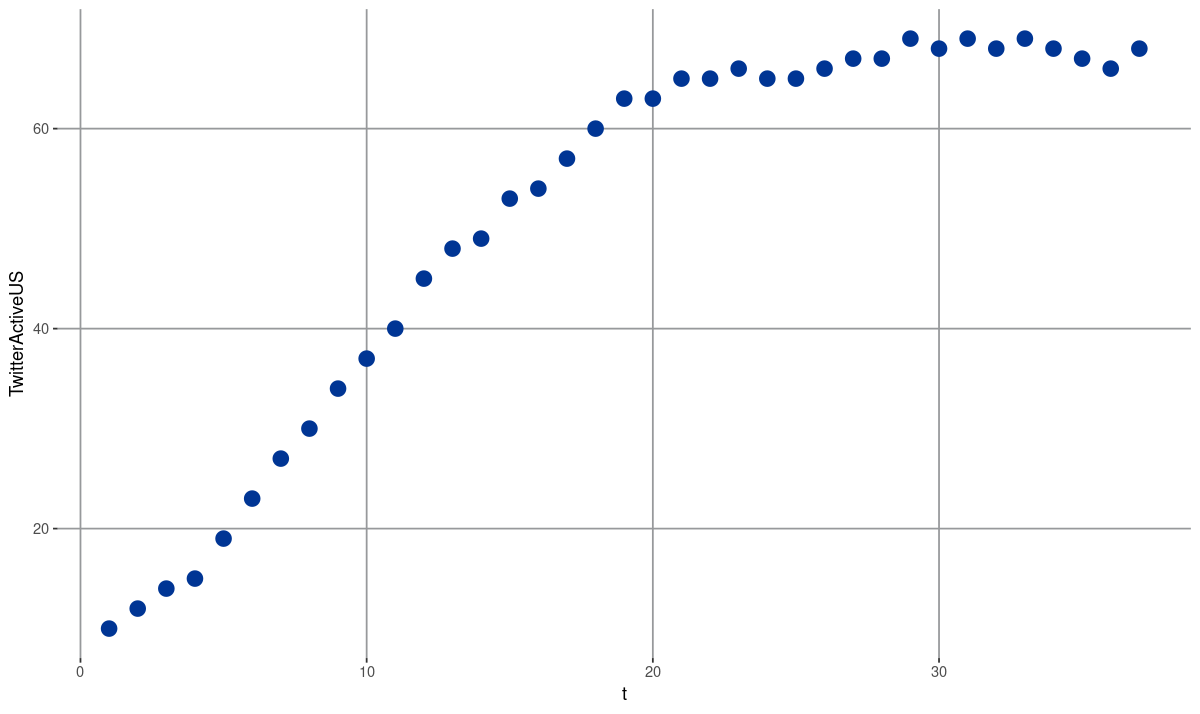

In [10]:
twitter.us<-read.csv('social/TwitterUsers.csv')  
tail(twitter.us)
ggplot(twitter.us, aes(x=t, y=TwitterActiveUS)) +
  geom_point(size=4,color=Pitt.Blue )+Pitt.Theme

So here we have a function with a single observable input $t$, and three parameters $\boldsymbol{\beta}=(\alpha,\gamma,\lambda)$ in:
$$ f(t)=\frac{\alpha}{1+\gamma\exp(-\lambda t)}$$

We will estimate the parameters by attempting to minimize the total sum of squares:
$$ \text{Sum of Squares}(\boldsymbol{\beta})=\sum_i \left( y_i -f(t_i) \right)^2$$
which is given by:
$$ \text{Sum of Squares}(\boldsymbol{\beta})=\sum_i \left( y_i - \frac{\alpha}{1+\gamma\exp-\lambda t)}\right)^2$$

So we want to find the estimated value $\hat{\boldsymbol{\beta}}=\left(\alpha,\gamma,\lambda \right)$ that minimize this.

# Estimate the model

I'm going to write the objective function first:

In [15]:
non.lin.LS.obj<- function(beta) sum( (twitter.us$TwitterActiveUS -
                                      beta[1]/(1+beta[2]*exp(-beta[3] * twitter.us$t)))**2)
non.lin.LS.obj(c(68,2,0.14))

[1] 2004.875

and then optimize it using the base Nelder-Mead solver via:

``` optim(fn =non.lin.LS.obj, par=c( ? ,?, ?) )```

However, I need to tell the routine some starting values. Here I quickly calibrate things, using my understanding of the model

Looking at the model:
$$ f(t)=\frac{\alpha}{1+\gamma \cdot e^{-\lambda t}}$$
We know that 
* $\alpha$ is the amount of users as $t\rightarrow\infty$

In [16]:
tail(twitter.us) 

,year,q,TwitterActiveUS,t
,<int>,<int>,<int>,<int>
32,2017,4,68,32
33,2018,1,69,33
34,2018,2,68,34
35,2018,3,67,35
36,2018,4,66,36
37,2019,1,68,37


In [17]:
alpha0 <- 69

So I set $\alpha_0$ as the last value 68. Using this value, I can guess a value for $\gamma_0$ because at time zero we have that:
$$f(0)=\frac{\alpha_0}{1+\gamma_0}=9$$
which I can invert to get a guess for $\gamma_0$.

In [ ]:
head(twitter.us)

In [18]:
gamma0 <- (alpha0/9 - 1 )
gamma0

[1] 6.666667

Finally, for the logistic function, the inflection point where the slope stops increasing is given by $t=\frac{\log(\gamma)}{\lambda}$. If we ballpark this at happening at $t=10$ in the data we can guess a value of $\lambda_0$

In [19]:
lambda0<-log(gamma0)/10 
lambda0

[1] 0.189712

### Running the estimation:

In [23]:
twitter.opt<-optim(fn =non.lin.LS.obj, par=c( alpha0, gamma0, lambda0) ,hessian=TRUE)
estimated.params<-twitter.opt$par
names(estimated.params)<-c("alpha","gamma","lambda")
estimated.params
sigma.hat.sq <- twitter.opt$value/(nrow(twitter.us)-3)
# Residual std. error
sqrt(sigma.hat.sq)
logis.f(100,alpha=68.4,gamma=7.525,lambda=0.219)

alpha      gamma     lambda 
68.3855407  7.5250072  0.2187244

[1] 0.9783976

[1] 68.4

### Plotting the output:

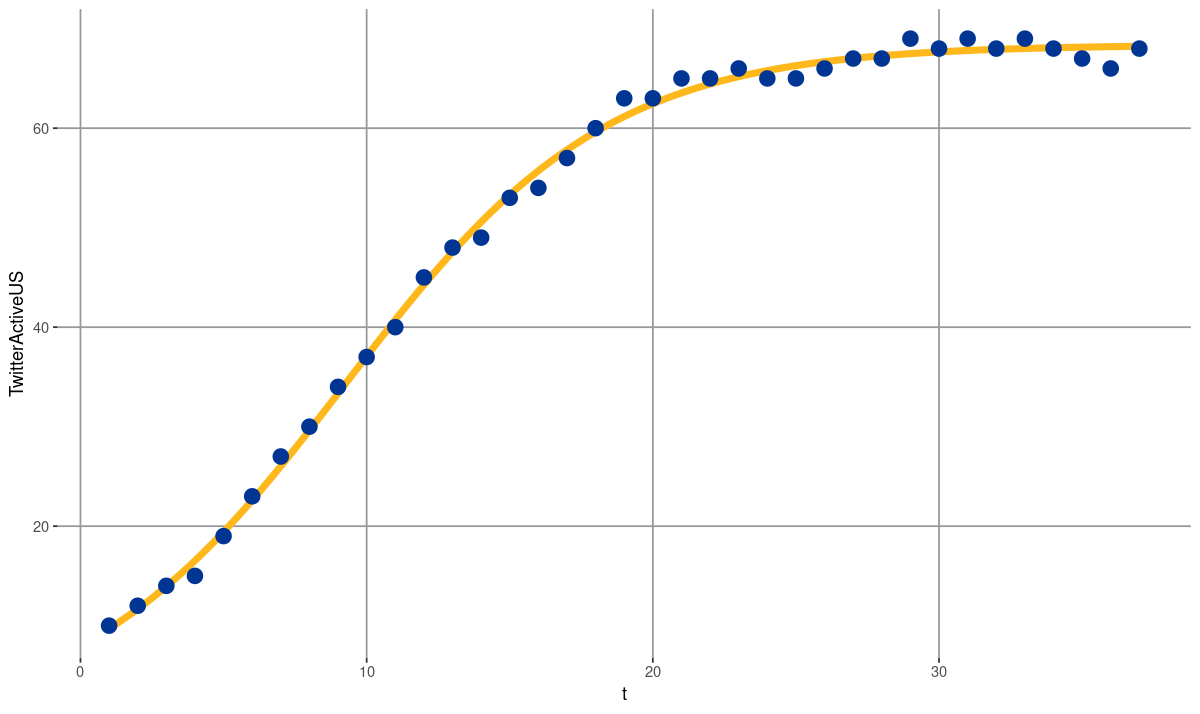

In [24]:
ggplot(twitter.us, aes(x=t, y=TwitterActiveUS)) +
stat_function(fun=logis.f,
              args=list(alpha = estimated.params["alpha"] ,
                        gamma =estimated.params["gamma"], 
                        lambda=estimated.params["lambda"]), color=Pitt.Gold,linewidth=2)+
  geom_point(size=4,color=Pitt.Blue ) + Pitt.Theme

So we now have a working model to forecast the number of active US twitter users going forward (in millions):
$$ f(t)=\frac{ 68.38 }{1+7.53e^{-0.219\cdot t}} $$

## Standard errors and inference
* Inference for these models is similar to OLS models, in that we can generate standard errors for our each of our estimates, generate confidence intervals, etc.
* Inferential tests based on the parameters are then based on asymptotic notions over the amount of data $n$ and Taylor expansions
* We will not dwell on the formulas for the standard errors here, and will come back to this a little when we talk about the delta-method and maximum likelihood estimations
* In a second we'll switch to an R package that computes the standard errors for us, but here is some example code to generate the variance-covariance matrix for the estimates

In [27]:
#install.packages('numDeriv')
eps<-1e-8
# this is the function f asssessed at tje entire vector of inputs
non.lin.LS.f<- function(beta)  beta[1]/(1+beta[2]*exp(-beta[3] * twitter.us$t))
# take a simple numerical partial derivative for each data row, and for each parameter so k x n matrix
g<-rbind( (non.lin.LS.f(estimated.params+c(eps,0,0))-non.lin.LS.f(estimated.params))/eps,(non.lin.LS.f(estimated.params+c(0,eps,0))-non.lin.LS.f(estimated.params))/eps, (non.lin.LS.f(estimated.params+c(0,0,eps))-non.lin.LS.f(estimated.params))/eps)
# take the quadratic product of this to get a k x k 
D.mat <- sigma.hat.sq*solve(g%*%t(g)) 
colnames(D.mat)<-c("alpha","gamma","lambda") 
rownames(D.mat)<-c("alpha","gamma","lambda")

This is the resulting variance-covariance matrix:

In [28]:
D.mat
sqrt(0.0855) 

,alpha,gamma,lambda
alpha,0.0855348553,-0.025979718,-7.476524e-04
gamma,-0.0259797181,0.094428080,1.187689e-03
lambda,-0.0007476524,0.001187689,1.960518e-05


[1] 0.2924038

It is also possible to make predictions through the model, but this also relies on constructing different standard errors, through derivatives of the parameters with respect to the model. 

Below I do this using some *analytical* derivatives

*(Note: We will come back to this when we talk about the **delta-method**)*

In [29]:
g.D<-function(t) {
    alpha<-estimated.params["alpha"]
    gamma<-estimated.params["gamma"]
    lambda<-estimated.params["lambda"]
    sigma<-sigma.hat.sq
    # Analytical derivative 
    gderiv<-c( (1+gamma* exp(-lambda*t)), -alpha*exp(-lambda*t), alpha*gamma*t*exp(-lambda*t))/(1+gamma*exp(-lambda*t))^2
    modelest<- alpha/(1+gamma*exp(-lambda*t))
    se<-sqrt(t(gderiv)%*%D.mat%*%gderiv)
    out<-c(t,modelest,modelest-1.96*se,modelest+1.96*se,modelest-1.96*(se+sigma),modelest+1.96*(se+sigma))
    names(out)<-c("t","model","lcl","ucl","lpred","upred")
    return(out) 
}
outModel<-data.frame(t(sapply(c(-4:70),g.D))) 

And so we can plot the resulting confidence interval for both the model, and the prediction.

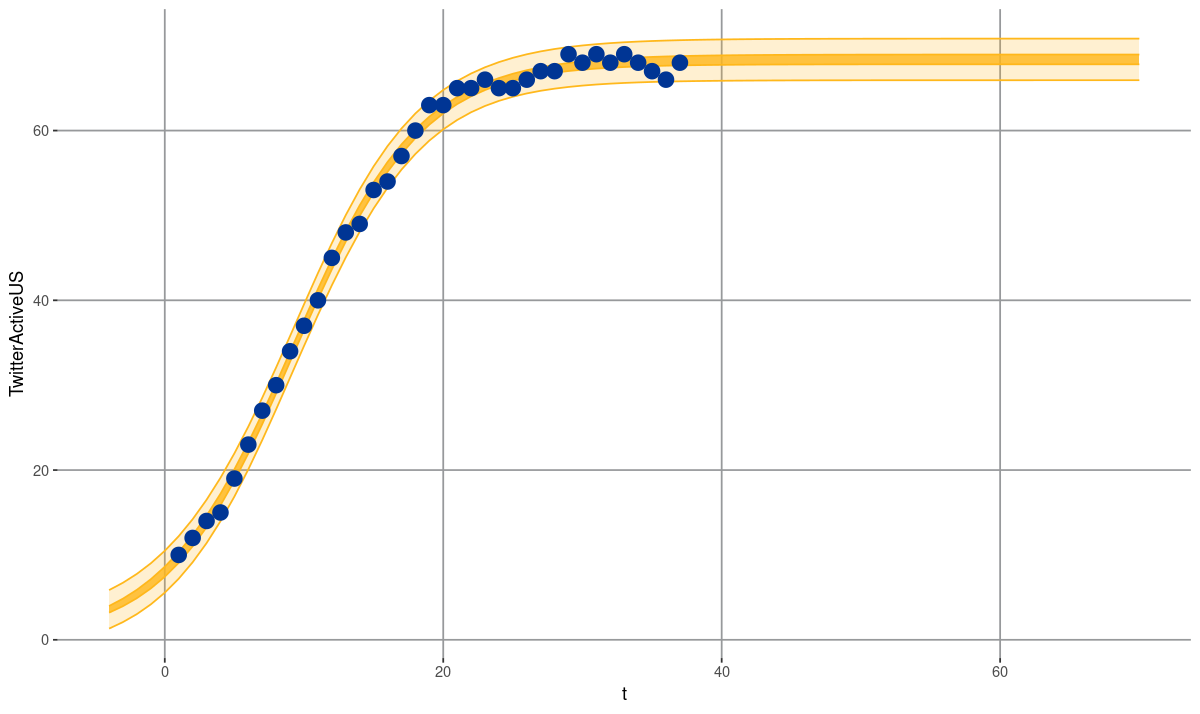

In [30]:
ggplot(twitter.us, aes(x=t, y=TwitterActiveUS))+
geom_ribbon(data=outModel,aes(x=t,y=model,ymin=lcl,ymax=ucl),color=Pitt.Gold, alpha=0.8,fill=Pitt.Gold)+
geom_ribbon(data=outModel,aes(x=t,y=model,ymin=lpred,ymax=upred),color=Pitt.Gold, alpha=0.2,fill=Pitt.Gold)+
geom_point(size=4,color=Pitt.Blue )+Pitt.Theme

### Using an R package
Let's install a package for running NLS models:

In [31]:
#install.packages('stats')
library(stats)
nl.twitter.model<- nls( formula=TwitterActiveUS ~  alpha/( 1+ gamma*exp(-lambda*t) ) , 
                      data=twitter.us, 
                      start=list(alpha=alpha0, gamma=gamma0, lambda=lambda0))
summary(nl.twitter.model)


Formula: TwitterActiveUS ~ alpha/(1 + gamma * exp(-lambda * t))

Parameters:
        Estimate Std. Error t value Pr(>|t|)    
alpha  68.385392   0.292463  233.83   <2e-16 ***
gamma   7.524794   0.307281   24.49   <2e-16 ***
lambda  0.218724   0.004428   49.40   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9784 on 34 degrees of freedom

Number of iterations to convergence: 4 
Achieved convergence tolerance: 8.785e-07


So we can construct confidence intervals the same way we would for a linear model (the package adds a method for this)

In [32]:
confint(nl.twitter.model,level=0.95)

Waiting for profiling to be done...



,2.5%,97.5%
alpha,67.7991666,68.9835856
gamma,6.9394741,8.1831832
lambda,0.2099943,0.2278055


Here is the estimated variance covariance matrix from the R package which we can compare to the one we calculated above with the simple numerical derivatives:

In [33]:
vcov(nl.twitter.model)
D.mat

,alpha,gamma,lambda
alpha,0.0855343415,-0.025978584,-7.476533e-04
gamma,-0.0259785836,0.094421866,1.187652e-03
lambda,-0.0007476533,0.001187652,1.960534e-05


,alpha,gamma,lambda
alpha,0.0855348553,-0.025979718,-7.476524e-04
gamma,-0.0259797181,0.094428080,1.187689e-03
lambda,-0.0007476524,0.001187689,1.960518e-05


### Generate predictions:
Suppose we wanted to get some extrapolated values for Twitter's earlier years when we didn't have data to compare to our company's growth. Here we'll use the `predict` command in the same way you did for linear models!

In [34]:
# make some new data to prediction (needs a variable t !)
prev.years=data.frame("t"=c(0,-1,-2,-3,-4))
prev.years["prediction"]<- predict(nl.twitter.model, newdata=prev.years)
prev.years

t,prediction
<dbl>,<dbl>
0,8.021941
-1,6.598031
-2,5.404241
-3,4.411024
-4,3.589941


Confidence intervals do not work in the current implementation though!

In [36]:
 predict( nl.twitter.model, newdata=data.frame(t=-5) , interval="prediction", level=0.95)

[1] 2.914733

Below does work, but it takes more time per prediciton as it uses some boostrapping/simulation, we'll come back to this in upcoming classes

In [37]:
#install.packages('propagate')
library(propagate)

Loading required package: MASS

Loading required package: tmvtnorm

Loading required package: mvtnorm

Loading required package: Matrix

Loading required package: stats4

Loading required package: gmm

Loading required package: sandwich

Loading required package: Rcpp

Loading required package: ff

Loading required package: bit


Attaching package: ‘bit’


The following object is masked from ‘package:base’:

    xor


Attaching package ff

- getOption("fftempdir")=="/tmp/RtmpVY8Zej/ff"


- getOption("ffextension")=="ff"


- getOption("ffdrop")==TRUE


- getOption("fffinonexit")==TRUE


- getOption("ffpagesize")==65536


- getOption("ffcaching")=="mmnoflush"  -- consider "ffeachflush" if your system stalls on large writes


- getOption("ffbatchbytes")==16777216 -- consider a different value for tuning your system


- getOption("ffmaxbytes")==536870912 -- consider a different value for tuning your system



Attaching package: ‘ff’


The following objects are masked from ‘package:utils’:


Run a prediction (that allows for the disturbance term error)

In [38]:
predictions.twitter<-predictNLS( nl.twitter.model, newdata= prev.years["t"] , interval="prediction", quietly=TRUE)

predictNLS: Propagating predictor value #1...

predictNLS: Propagating predictor value #2...

predictNLS: Propagating predictor value #3...

predictNLS: Propagating predictor value #4...

predictNLS: Propagating predictor value #5...



In [39]:
predictions.twitter

Results from uncertainty propagation:

Results from Monte Carlo simulation:

Results from uncertainty propagation:

Results from Monte Carlo simulation:

Results from uncertainty propagation:

Results from Monte Carlo simulation:

Results from uncertainty propagation:

Results from Monte Carlo simulation:

Results from uncertainty propagation:

Results from Monte Carlo simulation:



$summary
  Prop.Mean.1 Prop.Mean.2 Prop.sd.1 Prop.sd.2 Prop.2.5% Prop.97.5% Sim.Mean
1    8.021941    8.032721 1.0236138 1.0237280  5.952255  10.113187 8.034067
2    6.598031    6.608186 1.0168912 1.0169927  4.541408   8.674964 6.609568
3    5.404241    5.413732 1.0102373 1.0103261  3.360502   7.466961 5.415178
4    4.411024    4.419824 1.0040791 1.0041555  2.379134   6.460514 4.421681
5    3.589941    3.598035 0.9986645 0.9987293  1.568373   5.627697 3.597427
    Sim.sd Sim.Median  Sim.MAD Sim.2.5% Sim.97.5%
1 1.054433   8.033090 1.035129 5.956304 10.118714
2 1.047890   6.608000 1.029035 4.549613  8.678947
3 1.041451   5.415365 1.021659 3.364737  7.465944
4 1.034914   4.422038 1.015494 2.382521  6.458153
5 1.030838   3.597753 1.011072 1.569719  5.630470

$prop
$prop[[1]]
   Mean.1    Mean.2      sd.1      sd.2      2.5%     97.5% 
 8.021941  8.032721  1.023614  1.023728  5.952255 10.113187 
     Mean        sd    Median       MAD      2.5%     97.5% 
 8.034067  1.054433  8.033090  1.0

In [40]:
confidence.twitter<-predictNLS( nl.twitter.model, newdata= prev.years["t"] , interval="confidence", quietly=TRUE)

predictNLS: Propagating predictor value #1...

predictNLS: Propagating predictor value #2...

predictNLS: Propagating predictor value #3...

predictNLS: Propagating predictor value #4...

predictNLS: Propagating predictor value #5...



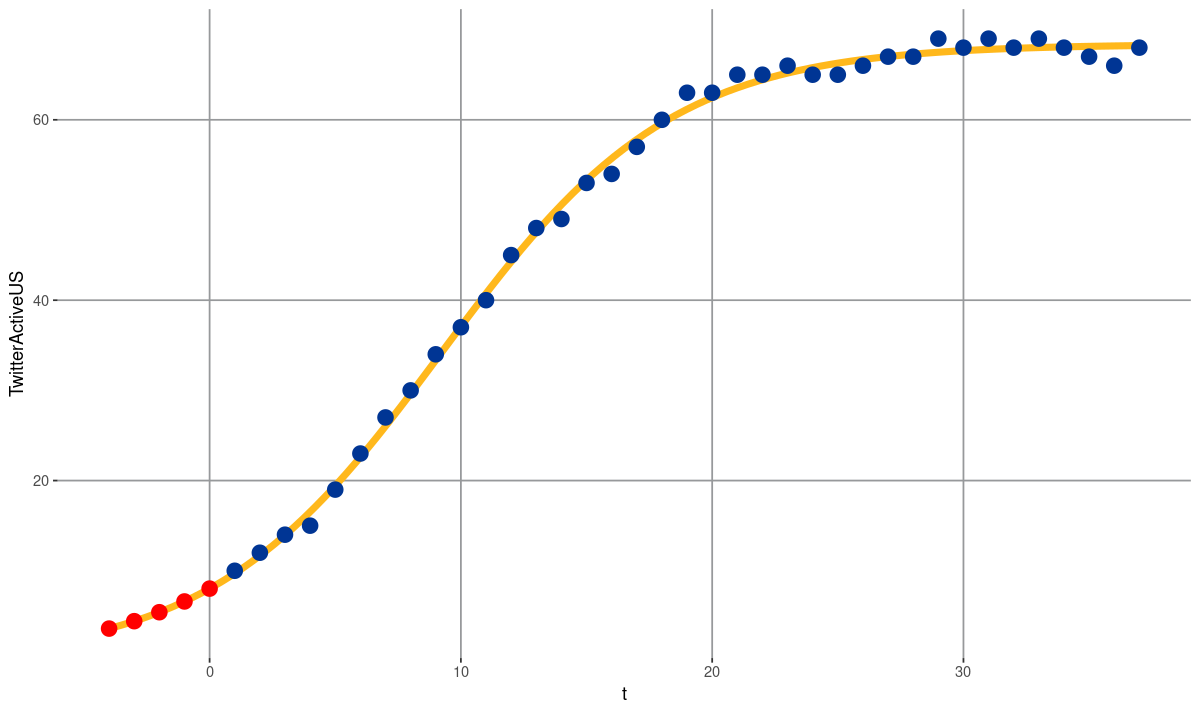

In [41]:
ggplot(twitter.us, aes(x=t, y=TwitterActiveUS)) +stat_function(fun=logis.f,args=list(alpha = estimated.params["alpha"] ,gamma =estimated.params["gamma"], lambda=estimated.params["lambda"]), color=Pitt.Gold,linewidth=2)+
    geom_point(size=4,color=Pitt.Blue )+
    geom_point(size=4,color="red",data=prev.years,aes(x=t,y=prediction))+Pitt.Theme

### Model misspecification
One warning here is that the non-linear model assumption is held constant. Your standard errors and other inference will be made under the maintained assumption that the model is correct.

As an example, let's look at some publically available data for the growth of SnapChat's user base:

In [44]:
snapchat.all<-read.csv('social/SnapchatUsers.csv')
head(snapchat.all)

,year,q,snapchatDailyAll,t
,<int>,<int>,<int>,<int>
1,2014,1,46,1
2,2014,2,57,2
3,2014,3,62,3
4,2014,4,71,4
5,2015,1,80,5
6,2015,2,86,6


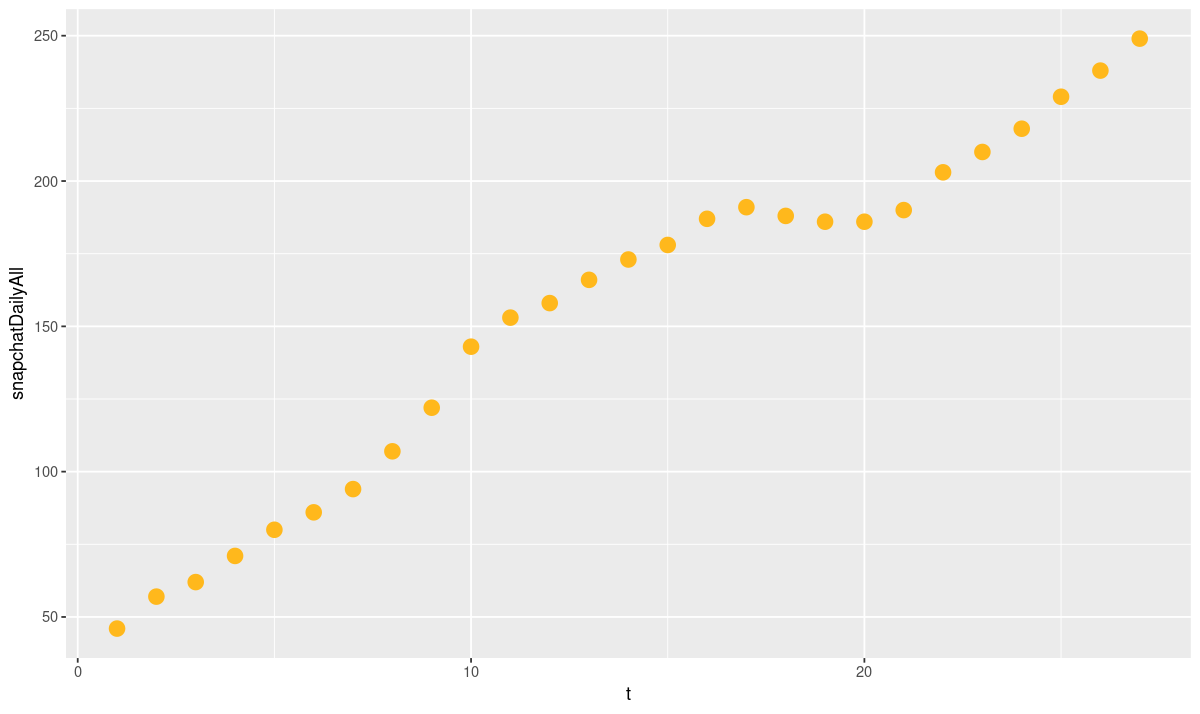

In [45]:
ggplot(snapchat.all, aes(x=t, y=snapchatDailyAll)) + 
  geom_point(size=4,color=Pitt.Gold )  

Guess some new initial values from the above graph (300 million asmpytote, 48 million at time 0, inflection point at t=15)

In [46]:
alpha0  <- 300
gamma0  <- alpha0/48-1
lambda0 <- log(gamma0)/15

We can again easily fit the non-linear logistic-map model using the `nls()` function:

In [47]:
nl.snapchat.model<-nls( snapchatDailyAll ~ (alpha/( 1+gamma*exp(-lambda*t))),  data=snapchat.all, start=list(alpha=alpha0, gamma=gamma0, lambda=lambda0) )
summary(nl.snapchat.model)
opt.snap<-coef(nl.snapchat.model)


Formula: snapchatDailyAll ~ (alpha/(1 + gamma * exp(-lambda * t)))

Parameters:
        Estimate Std. Error t value Pr(>|t|)    
alpha  235.17665    7.84895  29.963  < 2e-16 ***
gamma    4.38649    0.45668   9.605 1.07e-09 ***
lambda   0.17041    0.01575  10.818 1.04e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.4 on 24 degrees of freedom

Number of iterations to convergence: 9 
Achieved convergence tolerance: 3.144e-06


**Question:** Looking at these results are you worried about anything here?

Graphing the fitted function: *(note `coef(nl.snapchat.model)` is the exact right list to pass to the function!)*

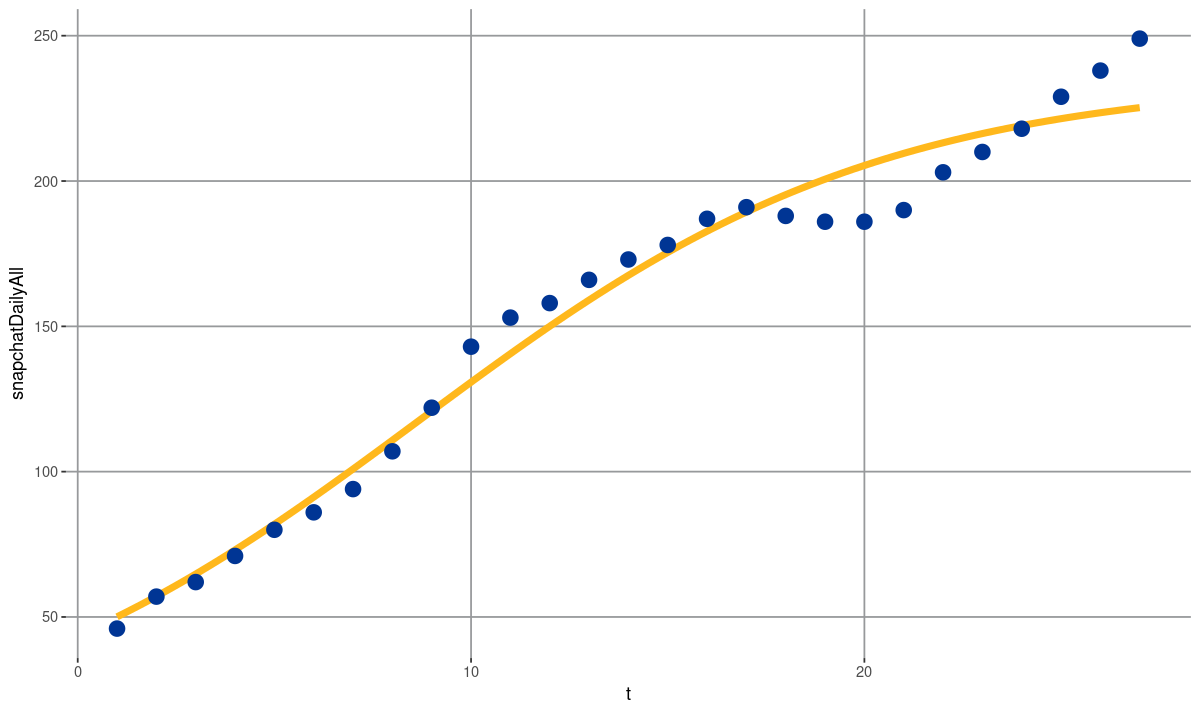

In [48]:
ggplot(snapchat.all, aes(x=t, y=snapchatDailyAll)) +stat_function(fun=logis.f,args= opt.snap , color=Pitt.Gold,linewidth=2)+
  geom_point(size=4,color=Pitt.Blue )+Pitt.Theme

The reason we're getting such significance doesn't seem to be a function of our initial parameters:

In [49]:
summary( nls( snapchatDailyAll ~ (alpha/( 1+gamma*exp(-lambda*t))), 
             data=snapchat.all, start=list(alpha=10000, gamma=1000/20, lambda=0.01) ) )



Formula: snapchatDailyAll ~ (alpha/(1 + gamma * exp(-lambda * t)))

Parameters:
        Estimate Std. Error t value Pr(>|t|)    
alpha  235.17637    7.84889  29.963  < 2e-16 ***
gamma    4.38650    0.45668   9.605 1.07e-09 ***
lambda   0.17041    0.01575  10.818 1.04e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.4 on 24 degrees of freedom

Number of iterations to convergence: 18 
Achieved convergence tolerance: 2.852e-06


The problem here is that our assumptions about the functional form lock down the parameters fairly well in terms of independent moves of each. 

In [50]:
non.lin.LS.obj.snapchat<- function(alpha,gamma,lambda) sqrt(mean( (snapchat.all$snapchatDailyAll - alpha/(1+gamma*exp(-lambda*snapchat.all$t)))**2))
non.lin.LS.obj.snapchat.rel<- function(alpha,gamma,lambda) (non.lin.LS.obj.snapchat(alpha,gamma,lambda)-non.lin.LS.obj.snapchat(opt.snap["alpha"],opt.snap["gamma"],opt.snap["lambda"]))/non.lin.LS.obj.snapchat(opt.snap["alpha"],opt.snap["gamma"],opt.snap["lambda"])
non.lin.LS.obj.snapchat.alpha<- function(alpha) non.lin.LS.obj.snapchat.rel(alpha,opt.snap["gamma"],opt.snap["lambda"])

Holding constant the other parameters, and looking at how the value of the objective shifts with the $\alpha$ parameter:

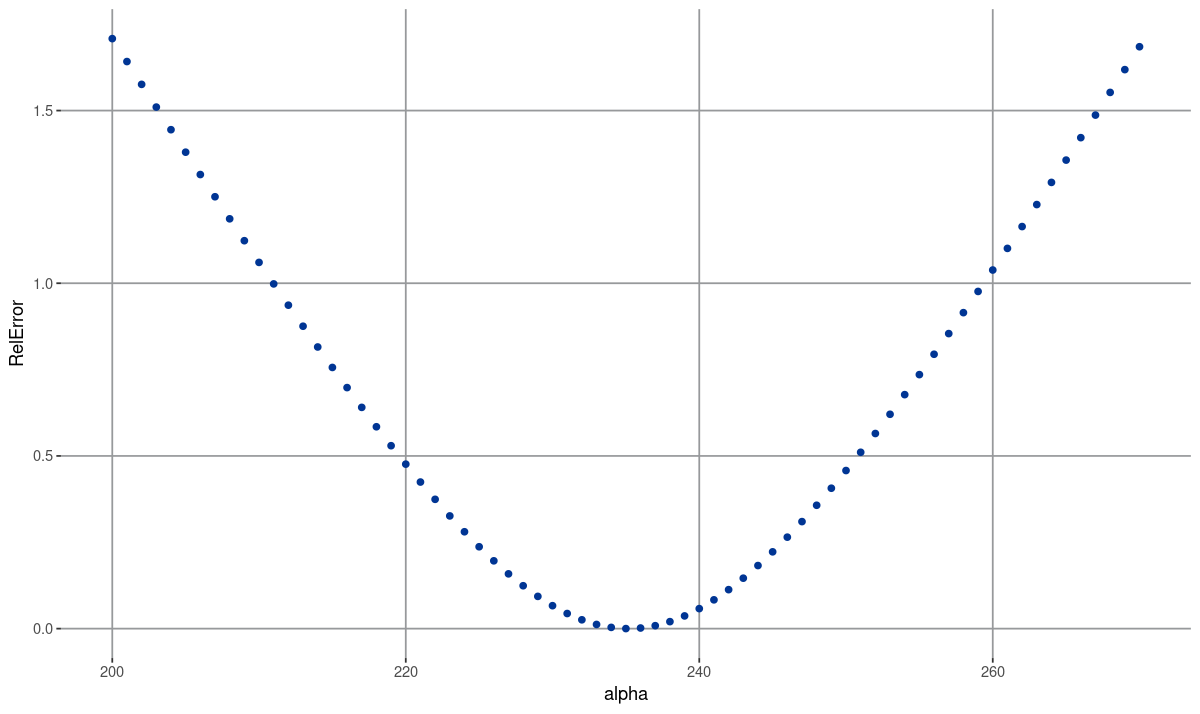

In [52]:
ChangeObj<-sapply(200:270,non.lin.LS.obj.snapchat.alpha)
ObjResponse<-data.frame("alpha"=c(200:270), "RelError"=ChangeObj)
ggplot(data=ObjResponse, aes(x=alpha,y=RelError))+geom_point(color=Pitt.Blue)+Pitt.Theme

We can also play with the parameters jointly, to see if we can find a better fit...

[1] 0

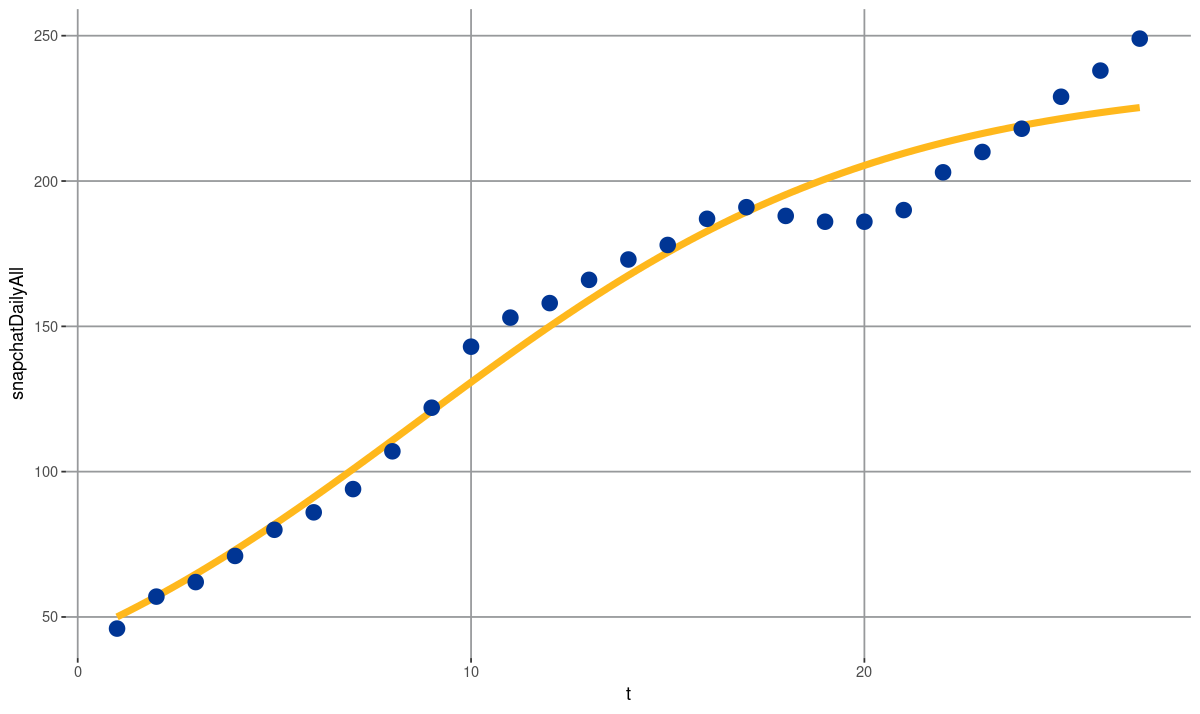

In [53]:
alphaIn<-235.2 # Asymptote number of users
time0value<- 43.63 # time 0 value
inflectionTime<-8.68 # Inflection time
# How much worse than optimal objective value
round(100*non.lin.LS.obj.snapchat.rel( alphaIn, (alphaIn/time0value -1),log(alphaIn/time0value -1)/inflectionTime),3)
ggplot(snapchat.all, aes(x=t, y=snapchatDailyAll)) +stat_function(fun=logis.f,args=list(alpha = alphaIn ,gamma = alphaIn/time0value -1, lambda=log(alphaIn/time0value -1)/inflectionTime), color=Pitt.Gold,linewidth=2)+
  geom_point(size=4,color=Pitt.Blue )+Pitt.Theme# + geom_point(size=4,color="red",data=subset(snapchat.alt, t>27),aes(x=t,y=Total))


Given the functional form, the parameters are fairly well estimated.

### Making the model richer
Let's modify the model adding a vertical shift parameter, and show that it can be well estimated with the **Twitter** data.

In [54]:
nl.twitter.model.2 <-nls(TwitterActiveUS ~ (intercept + alpha/( 1+gamma*exp(-lambda*t))),  
                         data=twitter.us, 
                         start=list(alpha= 10, gamma=2, lambda= 0.219654,intercept=0) )
summary(nl.twitter.model.2)


Formula: TwitterActiveUS ~ (intercept + alpha/(1 + gamma * exp(-lambda * 
    t)))

Parameters:
           Estimate Std. Error t value Pr(>|t|)    
alpha     68.145526   2.101579  32.426  < 2e-16 ***
gamma      7.647199   1.127174   6.784 9.78e-08 ***
lambda     0.219654   0.009403  23.360  < 2e-16 ***
intercept  0.222853   1.926462   0.116    0.909    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9929 on 33 degrees of freedom

Number of iterations to convergence: 7 
Achieved convergence tolerance: 9.057e-06


**Question:** Are the estimated parameters sensitive to the initial conditions?

Let's plot the fitted function:

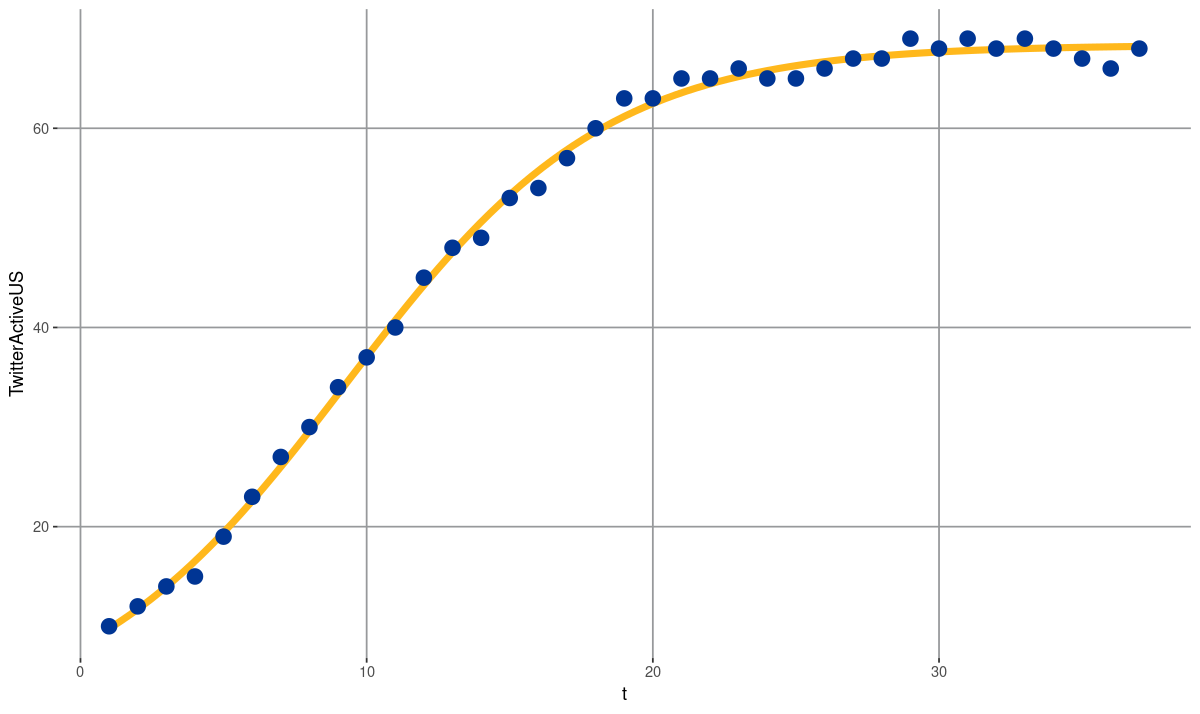

In [55]:
logis.f.c<-function(t,alpha,gamma,lambda,intercept) intercept+alpha/(1+gamma*exp(-lambda *t))
ggplot(twitter.us, aes(x=t, y=TwitterActiveUS)) +stat_function(fun=logis.f.c,args=list(alpha = 68.145633 ,gamma =7.647187, lambda=0.219654,intercept= 0.22276), color=Pitt.Gold,linewidth=2)+
  geom_point(size=4,color=Pitt.Blue )+Pitt.Theme

### Moving on to the Snapchat data...
In the twitter data, there's enough curvature to the model for us to estimate all of the effects relatively precisely, but as we saw, the non-linear features of the model dont' really show up well in the Snapchat data.

However, as we generalize the snapchat data model, the NLS package estimation fails to converge from this starting point.

In [56]:
nl.snapchat.model.2<-nls( snapchatDailyAll ~ (intercept+ alpha/( 1+ gamma*exp(-lambda*t))),  data=snapchat.all, start=list(alpha=300, gamma=4.38650, lambda=0.07,intercept=0) )
summary(nl.snapchat.model.2)

ERROR: Error in nls(snapchatDailyAll ~ (intercept + alpha/(1 + gamma * exp(-lambda * : singular gradient


Manually generating the objective function so we can use a different solver (here Nelder-Mead)

In [57]:
non.lin.LS.obj.constant<- function(beta) sum( (snapchat.all$snapchatDailyAll - beta[4]- beta[1]/(1+beta[2]*exp(-beta[3] * snapchat.all$t)))**2)

Running the optimization we find:

In [58]:
optim1 <- optim(fn =non.lin.LS.obj.constant, par=c(235.2,4.38650,0.17,0) )
optim1 # Note the $convergence value

$par
[1]  454.12014991    1.07108519    0.09394362 -187.52700524

$value
[1] 2188.762

$counts
function gradient 
     501       NA 

$convergence
[1] 1

$message
NULL

 Let's look in the [R manual](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/optim) to see what this code means.

So, we've reached the maximum iterations, lets start again, using the previous output as the new starting point.

In [60]:
optim2<-optim(fn =non.lin.LS.obj.constant, par=optim1$par)
optim2 

$par
[1]  654.84921660    0.62832807    0.07569238 -372.84775310

$value
[1] 2160.309

$counts
function gradient 
     501       NA 

$convergence
[1] 1

$message
NULL

In [61]:
optim3<-optim(fn =non.lin.LS.obj.constant, par=optim2$par)
optim3

$par
[1]  761.86401069    0.51358229    0.07049255 -474.70733279

$value
[1] 2155.313

$counts
function gradient 
     501       NA 

$convergence
[1] 1

$message
NULL

Let's look at the two parameter estimates we have

In [62]:
optim1$par
optim3$par

[1]  454.12014991    1.07108519    0.09394362 -187.52700524

[1]  761.86401069    0.51358229    0.07049255 -474.70733279

And now we can plot out the two functions that we got from stage 1 and 3

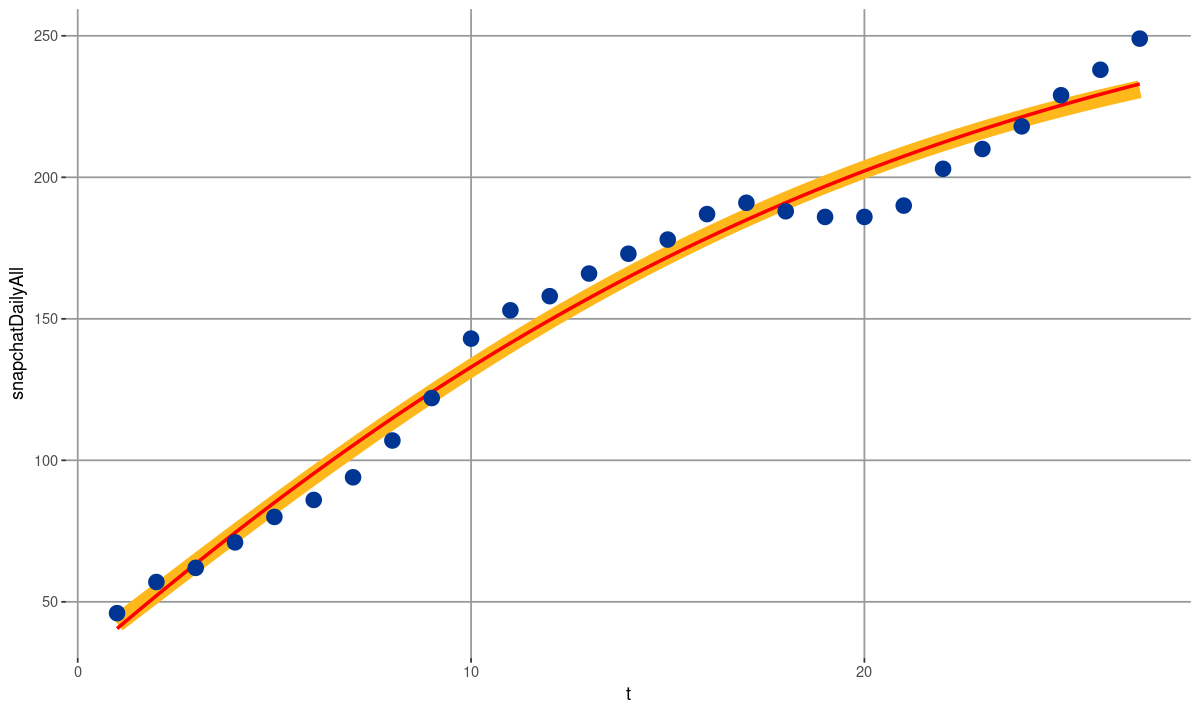

In [63]:
ggplot(snapchat.all, aes(x=t, y=snapchatDailyAll)) +
stat_function(fun=logis.f.c,args=list(alpha =optim1$par[1] ,gamma=optim1$par[2], lambda=optim1$par[3],intercept=optim1$par[4]), color=Pitt.Gold,linewidth=5)+
stat_function(fun=logis.f.c,args=list(alpha =optim3$par[1] ,gamma=optim3$par[2], lambda=optim3$par[3],intercept=optim3$par[4]), color="red",linewidth=1)+
geom_point(size=4,color=Pitt.Blue )+Pitt.Theme

But when you extrapolate out side of the data, the two models can have very different predictions!

In [64]:
# Look at t=80...
logis.f.c(80,optim1$par[1],optim1$par[2],optim1$par[3],optim1$par[4])
logis.f.c(80,optim3$par[1],optim3$par[2],optim3$par[3],optim3$par[4])

[1] 266.3284

[1] 285.7682

The problem here is that the function parameters are not well identified by the data once I allow for this change.

Looking at the actual data after this...

In [65]:
snapchat.alt<-read.csv('social/SnapchatAlt.csv')
head(snapchat.alt)

,t,q,year,Namerica,Europe,Total
,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,2014,26,14,46
2,2,2,2014,30,18,57
3,3,3,2014,32,20,62
4,4,4,2014,35,23,71
5,5,1,2015,38,27,80
6,6,2,2015,40,29,86


ggplot(snapchat.all, aes(x=t, y=snapchatDailyAll)) +
stat_function(fun=logis.f.c,args=list(alpha =optim1$par[1] ,gamma=optim1$par[2], lambda=optim1$par[3],intercept=optim1$par[4]), color=Pitt.Gold,linewidth=5)+
stat_function(fun=logis.f.c,args=list(alpha =optim3$par[1] ,gamma=optim3$par[2], lambda=optim3$par[3],intercept=optim3$par[4]), color="red",linewidth=1)+
geom_point(size=4,color=Pitt.Blue )+Pitt.Theme + geom_point(size=4,color="red",data=subset(snapchat.alt, t>27),aes(x=t,y=Total))

## Linear Models
The other idea is that we could maybe have captured some of this behavior by specifying the right linear model

In [67]:
twitter.lm<-lm(log(TwitterActiveUS)~t+I(t^2)+I(t^3),data=twitter.us)
twitter.us["lin.pred"]<- exp(predict(twitter.lm))
summary(twitter.lm)
beta.lm<-coef(twitter.lm)


Call:
lm(formula = log(TwitterActiveUS) ~ t + I(t^2) + I(t^3), data = twitter.us)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.112810 -0.010335  0.000609  0.019509  0.040040 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.048e+00  2.148e-02   95.35   <2e-16 ***
t            2.221e-01  4.830e-03   45.98   <2e-16 ***
I(t^2)      -7.555e-03  2.932e-04  -25.76   <2e-16 ***
I(t^3)       8.503e-05  5.077e-06   16.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02941 on 33 degrees of freedom
Multiple R-squared:  0.9975,	Adjusted R-squared:  0.9973 
F-statistic:  4402 on 3 and 33 DF,  p-value: < 2.2e-16


In [68]:
twitter.lm.pred<-function(t) exp(  beta.lm["(Intercept)"]+beta.lm["t"]*t+beta.lm["I(t^2)"]*t**2+beta.lm["I(t^3)"]*t**3 )
twitter.lm.pred(5)

(Intercept) 
   19.69072

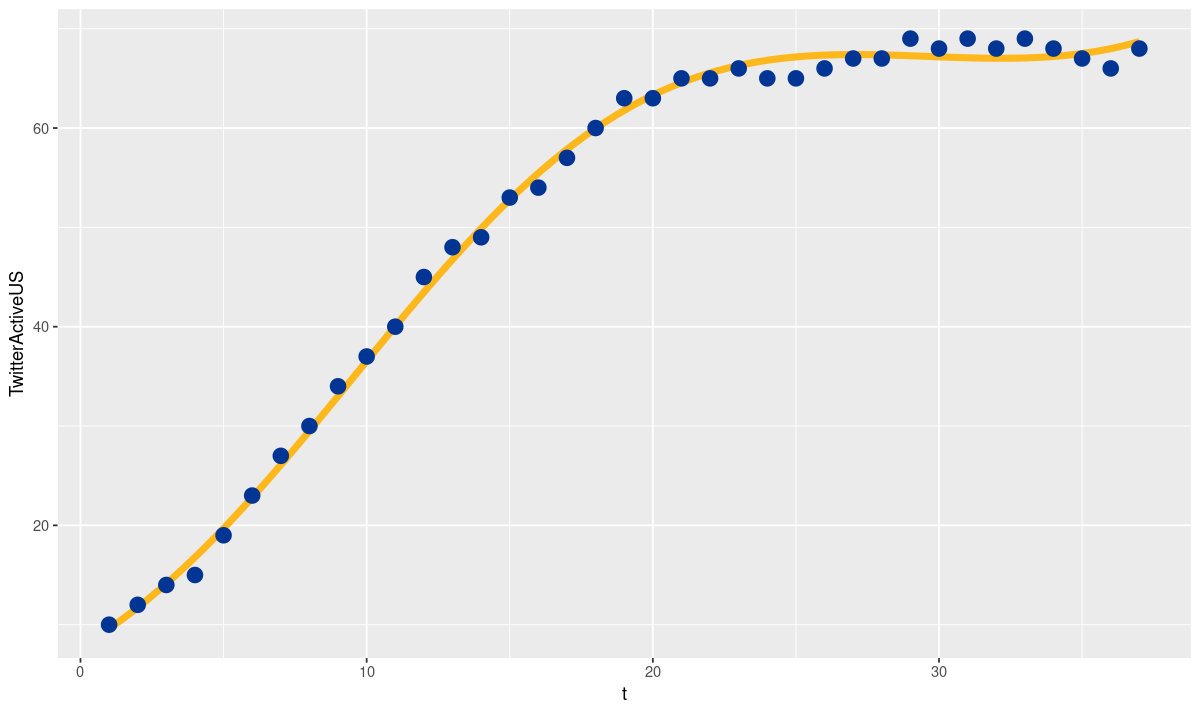

In [69]:
ggplot(twitter.us, aes(x=t, y=TwitterActiveUS)) +stat_function(fun=twitter.lm.pred, color=Pitt.Gold,linewidth=2)+
    geom_point(size=4,color=Pitt.Blue )

The problem here is that as we extrapolate, the functional form is maybe not doing what we want....

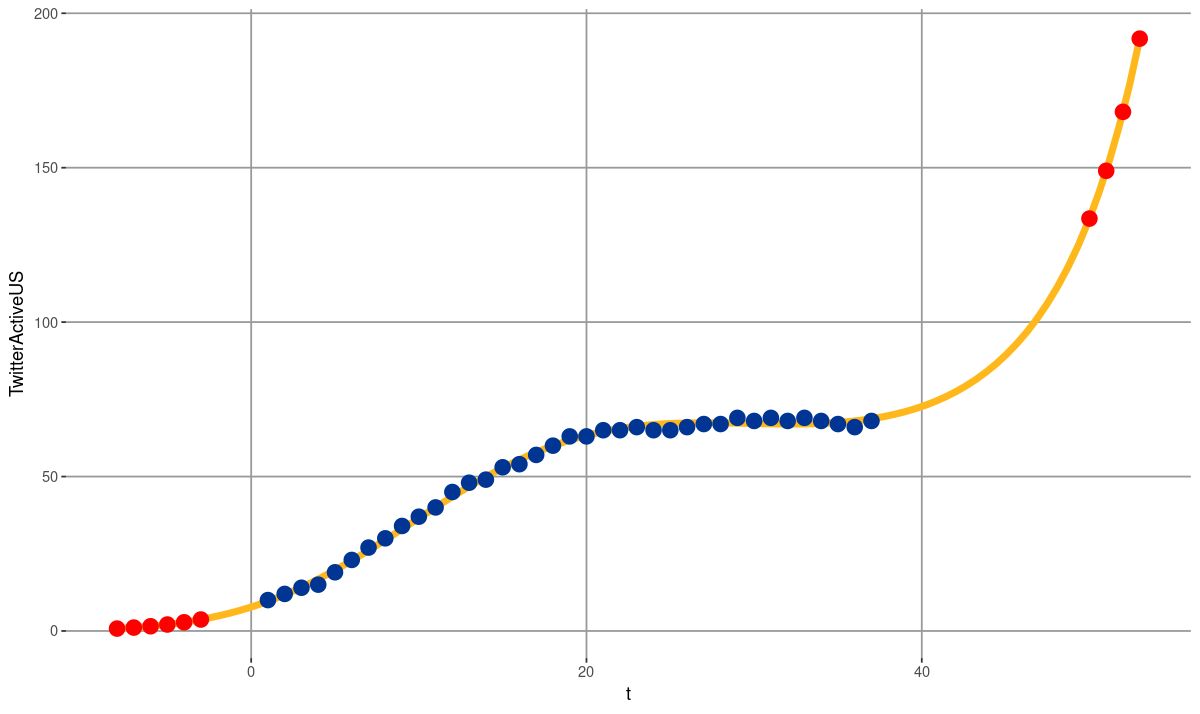

In [70]:
out.of.sample=data.frame("t"=c(-3,-4,-5,-6,-7,-8,50,51,52,53))
out.of.sample["prediction"]<- exp(predict(twitter.lm, newdata=out.of.sample))
ggplot(twitter.us, aes(x=t, y=TwitterActiveUS)) +stat_function(fun=twitter.lm.pred, color=Pitt.Gold,linewidth=2)+
    geom_point(size=4,color=Pitt.Blue )+ geom_point(size=4,color="red",data=out.of.sample,aes(x=t,y=prediction))+Pitt.Theme

So the benefit of the structure is that if you choose a non-linear function that you have a good reason to believe is appropriate, and that you understand it's effects, this can lead to more structured out-of-sample predictions

## Direct transformations
Some non-linear models can however be directly translated.

Consider the Cobb-Douglas model for how output is related to capital and labor inputs: $$ y=\beta \cdot C^\gamma L^{1-\gamma} $$

This model can be directly linearized to get:
$$\log(y)=\log(\beta)+\gamma\log(C)+(1-\gamma)\log(L)$$

So you could estimate the non-linear Cobb Douglas production model using a linear model by taking lof transformations of the outpus and inputs.

One difference between the linear model in logs and a non-linear model though is over how the econometric errors enter the equation.

In the non-linear model when it's set up as an NLS, you're looking at an equation with additive erors:
$$y=\beta \cdot C^\gamma L^{1-\gamma}+\epsilon$$

In contrast, in the linearized version of the model, the errors are really entering the underlying equation multiplicatively as:
$$y=\beta \cdot C^\gamma L^{1-\gamma}\cdot \exp(\epsilon)$$

So if you think about the errors as being log-normal, this is fine, but otherwise could be a little strange.

## Quantile Regression
Above, we broke from the linear-in-parameters restriction from the standard linear model, but we were continuing to try to and predict the conditional **mean**.

We now move to an analysis that attempts to predict a quantile of the population. To begin with, we'll focus on trying to predict the **median**.

**Question:** Why might we want to predict the median instead of the mean?

### How does quantile regression work?

OLS and Quantile Regression differ over the objective we attempt to minimize to find the parameters. These objective are illustrated by the following two costs attributed to errors in each.
* Blue is error squared
* Gold is absolute error

![Image](https://alistairjwilson.github.io/MQE_AW/i/LeastAbs.svg)

That is, in ordinary least squares you choose the $\beta$ parameters to minimize:
$$ \sum_i (y_i -x_i\beta)^2$$
In contrast, for least absolute deviations, we change the objective we minimize to:
$$ \sum_i \left|y_i -x_i\beta\right|$$

So show this can cause differences lets look at a quick example. Suppose we have $y$ observations $2$, $\tfrac{2}{5}$ and $\tfrac{-3}{5}$ and we're trying to find the intercept/mean $\mu$. The objective for OLS is therefore $$Q_{\text{OLS}}(\mu)=(2-\mu)^2+(\tfrac{2}{5}-\mu)^2+(-\tfrac{3}{5}-\mu)^2$$

Finding the solution to this can therefore be illustrated as:


![Image](https://alistairjwilson.github.io/MQE_AW/i/OLSopt.gif)

The formal solution to this comes from the FOC that:
$$Q^\prime_{\text{OLS}}(\mu)=-2\left[(2-\hat{\mu})+(\tfrac{2}{5}-\hat{\mu})(-\tfrac{3}{5}-\hat{\mu})\right]=0\Longrightarrow \hat{\mu}=\frac{2+\tfrac{2}{5}-\tfrac{3}{5}}{3}=\tfrac{3}{5}$$

So the errors for the three terms are $\tfrac{7}{5}$, $\tfrac{-1}{5}$ and $\tfrac{-6}{5}$, and the solution balances out the two smaller negative errors with the one big error. 

In contrast, for the least-absolute deviations objective we are trying to minimize:
$$Q_{\text{LAD}}(\mu)=|2-\mu|+|\tfrac{2}{5}-\mu|+|-\tfrac{3}{5}-\mu|$$
which is minimized at $\mu=\tfrac{2}{5}$, which is the median observation for the sample.

![Image](https://alistairjwilson.github.io/MQE_AW/i/Compareopt.gif)

## Why will it be the median?
Focus in on the animation just of the LAD problem here:

![Image](https://alistairjwilson.github.io/MQE_AW/i/MedOpt.gif)

Any changes to the parameter have exactly offsetting effects from the left and right points, so we just move the median point towards zero.

But this insight, leads to a generalization, suppose we have five points, but we make the left hand side of the tick three times steeper!?

![Image](https://alistairjwilson.github.io/MQE_AW/i/MedOpt2.gif)

* So the optimal parameter here will be such there are three times as many points to the left as to the right.

* With lots and lots of data points, this will be close to us the 25th percentile of the data.

* Hence, the  general method of quantile regression can be used to estimate different quantiles of the data by changing the relative slope of errors to the left and to the right.

### General Objective
So we can define the loss function that attempts to minimize the distance from the $\tau$-th quantile of the error distribution as:
$$ \rho_\tau\left(u \right)= \begin{cases}
-u\cdot(1-\tau) & \text{if } u<0   \\
 u\cdot\tau & \text{if } u\geq 0
\end{cases}$$

We can then look for the parameter vector $\boldsymbol{\beta}$ that minimizes:
$$ \sum_i \rho_\tau\bigl(y_i -\mathbf{x}_i \boldsymbol{\beta}\bigr)$$

## Finding parameters
* With meaningful regressors on the right-hand side of the model, we again have to use numerical methods to solve for the minimizing parameters. 

* Rather than numerically set this up and solve it again, let's jump straight to an R package that does this for us

In [73]:
#install.packages('quantreg')
library(quantreg)

In [74]:
house.sales <- read.csv('real_estate/sales_all.csv')

In [77]:
head(house.sales,1)

,X_id,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESSDIR,PROPERTYADDRESSSTREET,PROPERTYADDRESSSUF,PROPERTYADDRESSUNITDESC,PROPERTYUNITNO,PROPERTYCITY,⋯,MUNIDESC,RECORDDATE,SALEDATE,PRICE,DEEDBOOK,DEEDPAGE,SALECODE,SALEDESC,INSTRTYP,INSTRTYPDESC
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,30335251,1010G00075000000,0,,,HILL,ST,,,SOUTH PARK,⋯,South Park,2022-07-06,2022-06-21,1,18965,534,H,MULTI-PARCEL SALE,DE,DEED


In [78]:
colnames(house.sales)

[1] "X_id"                    "PARID"                  
 [3] "PROPERTYHOUSENUM"        "PROPERTYFRACTION"       
 [5] "PROPERTYADDRESSDIR"      "PROPERTYADDRESSSTREET"  
 [7] "PROPERTYADDRESSSUF"      "PROPERTYADDRESSUNITDESC"
 [9] "PROPERTYUNITNO"          "PROPERTYCITY"           
[11] "PROPERTYSTATE"           "PROPERTYZIP"            
[13] "SCHOOLCODE"              "SCHOOLDESC"             
[15] "MUNICODE"                "MUNIDESC"               
[17] "RECORDDATE"              "SALEDATE"               
[19] "PRICE"                   "DEEDBOOK"               
[21] "DEEDPAGE"                "SALECODE"               
[23] "SALEDESC"                "INSTRTYP"               
[25] "INSTRTYPDESC"

In [79]:
descs<-house.sales$SALEDESC
desc.vals<-unique(house.sales$SALEDESC)
occurences<- as.data.frame( table(descs))
head(occurences[order(-occurences$Freq), ],12)

,descs,Freq
,<fct>,<int>
14,LOVE AND AFFECTION SALE,84794
27,VALID SALE,74359
15,MULTI-PARCEL SALE,55642
21,QUIT CLAIM,39791
26,TIME ON MARKET (INSUFF/EXCESS),35927
19,OTHER INVALID SALES INDICATED,27463
18,OTHER,21261
22,SALE NOT ANALYZED,16293
7,CORRECTIVE DEED / DUPLICATE SALE,13813


Wrangle the data a little here:

In [80]:
valid.sales<-subset(house.sales, SALEDESC=="VALID SALE")
valid.sales["date"]<-as.Date(valid.sales$SALEDATE, format = "%Y-%m-%d")
valid.sales["m"] <-as.factor(format(valid.sales$date,"%m-%B"))
valid.sales["y"] <-as.factor(format(valid.sales$date,"%Y"))
valid.sales["month.n"] <-as.numeric(format(valid.sales$date,"%m"))
valid.sales["year.n"] <-as.numeric(format(valid.sales$date,"%Y"))
valid.sales["price"]<-as.numeric(valid.sales$PRICE)
valid.sales["t"]<- 12*(valid.sales["year.n"]-2016)+valid.sales["month.n"]
valid.sales["type"]<-factor(valid.sales$SALEDESC)

In [82]:
pred.data <-data.frame( unique(subset(valid.sales,y==2019)[c("m","y","t")]))
pred.data<-pred.data[order(pred.data$t), ]
pred.data$t<-pred.data$t-36
rownames(pred.data)<-pred.data$t
valid.sales["high.summer"]<-ifelse(valid.sales$month.n<=8 & valid.sales$month.n>=5,1,0)

In [83]:
ols.model.expec<- lm(price~ y + m , data=valid.sales)
summary(ols.model.expec)


Call:
lm(formula = price ~ y + m, data = valid.sales)

Residuals:
      Min        1Q    Median        3Q       Max 
  -316836   -112325    -49526     48897 124169717 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     177544      14435  12.299  < 2e-16 ***
y2013             1324      13335   0.099 0.920881    
y2014              430      15231   0.028 0.977477    
y2015             7280      14799   0.492 0.622775    
y2016            10300      13828   0.745 0.456378    
y2017             4336      13780   0.315 0.752996    
y2018            12190      14150   0.861 0.388973    
y2019            23139      15508   1.492 0.135686    
y2020            46683      13148   3.551 0.000385 ***
y2021            66557      13039   5.105 3.32e-07 ***
y2022            82779      12793   6.471 9.82e-11 ***
y2023            98877      12918   7.654 1.96e-14 ***
y2024            47456     562655   0.084 0.932785    
m02-February     -7491      12480  -0.600 0.54

In [84]:
 summary( lm(price~ y + high.summer , data=valid.sales) )


Call:
lm(formula = price ~ y + high.summer, data = valid.sales)

Residuals:
      Min        1Q    Median        3Q       Max 
  -306910   -112367    -49638     48653 124183863 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 185880.4    11648.0  15.958  < 2e-16 ***
y2013          901.7    13270.7   0.068 0.945830    
y2014          683.0    15137.1   0.045 0.964012    
y2015         7184.6    14734.2   0.488 0.625823    
y2016        10486.8    13756.1   0.762 0.445860    
y2017         3402.3    13698.8   0.248 0.803853    
y2018        11297.0    14089.3   0.802 0.422664    
y2019        21112.0    15438.6   1.367 0.171479    
y2020        46980.4    13109.4   3.584 0.000339 ***
y2021        66940.6    13010.1   5.145 2.68e-07 ***
y2022        82267.6    12734.1   6.460 1.05e-10 ***
y2023        98175.0    12850.8   7.640 2.20e-14 ***
y2024        39119.6   562616.8   0.070 0.944567    
high.summer  29354.9     4213.4   6.967 3.27e-12 ***
---
Signif.

In [85]:
pred.data["Expectation"]<-predict(object = ols.model.expec,newdata=pred.data)-177544-23139 # Subtracting Intercept and 2019 term.

In [86]:
pred.data["Expectation"] 

,Expectation
,<dbl>
1,0.5674723
2,-7490.4445696
3,4202.6031927
4,11702.4957743
5,23909.4640587
6,41108.2619535
7,32002.0814733
8,51414.3370870
9,18760.4878248


## Running a quantile regression
Let's run a quantile regression instead!

In [87]:
#install.packages('quantreg')
library(quantreg)

In [88]:
summary(valid.sales$year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2012    2016    2020    2019    2022    2024 

In [89]:
q.model.median<- rq( price~ y +m, data=valid.sales)
summary(q.model.median, se = "iid")

Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”



Call: rq(formula = price ~ y + m, data = valid.sales)

tau: [1] 0.5

Coefficients:
              Value        Std. Error   t value      Pr(>|t|)    
(Intercept)   122100.00000   3542.78541     34.46441      0.00000
y2013          -1200.00000   3272.65855     -0.36667      0.71386
y2014          17800.00000   3738.19113      4.76166      0.00000
y2015          25000.00000   3632.00935      6.88324      0.00000
y2016          14900.00000   3393.75804      4.39041      0.00001
y2017          22800.00000   3382.02764      6.74152      0.00000
y2018          28900.00000   3472.90002      8.32158      0.00000
y2019          32000.00000   3806.08077      8.40760      0.00000
y2020          58200.00000   3226.86547     18.03608      0.00000
y2021          72200.00000   3200.05295     22.56213      0.00000
y2022          88000.00000   3139.72640     28.02792      0.00000
y2023         102900.00000   3170.31463     32.45735      0.00000
y2024         102900.00000 138090.56688      0.74516      

In [90]:
# Generate Month-to-month differences
pred.data["Median"]<-predict(object = q.model.median,newdata=pred.data)-122100-32000
summary( rq(price~ y + high.summer , data=valid.sales) ,se = "iid")

Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”



Call: rq(formula = price ~ y + high.summer, data = valid.sales)

tau: [1] 0.5

Coefficients:
            Value        Std. Error   t value      Pr(>|t|)    
(Intercept) 132000.00000   3311.32446     39.86320      0.00000
y2013        -2000.00000   3772.63185     -0.53013      0.59602
y2014        17500.00000   4303.22129      4.06672      0.00005
y2015        26000.00000   4188.67918      6.20721      0.00000
y2016        16000.00000   3910.63492      4.09141      0.00004
y2017        22000.00000   3894.34641      5.64921      0.00000
y2018        28000.00000   4005.34981      6.99065      0.00000
y2019        30500.00000   4388.93115      6.94930      0.00000
y2020        58000.00000   3726.77991     15.56303      0.00000
y2021        73000.00000   3698.53829     19.73753      0.00000
y2022        88000.00000   3620.10217     24.30871      0.00000
y2023       103000.00000   3653.25153     28.19406      0.00000
y2024        93000.00000 159942.45461      0.58146      0.56093
high.summe

In [91]:
pred.data

,m,y,t,Expectation,Median
,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,01-January,2019,1,0.5674723,0
2,02-February,2019,2,-7490.4445696,0
3,03-March,2019,3,4202.6031927,8000
4,04-April,2019,4,11702.4957743,15000
5,05-May,2019,5,23909.4640587,25000
6,06-June,2019,6,41108.2619535,32779
7,07-July,2019,7,32002.0814733,25700
8,08-August,2019,8,51414.3370870,24900
9,09-September,2019,9,18760.4878248,20700


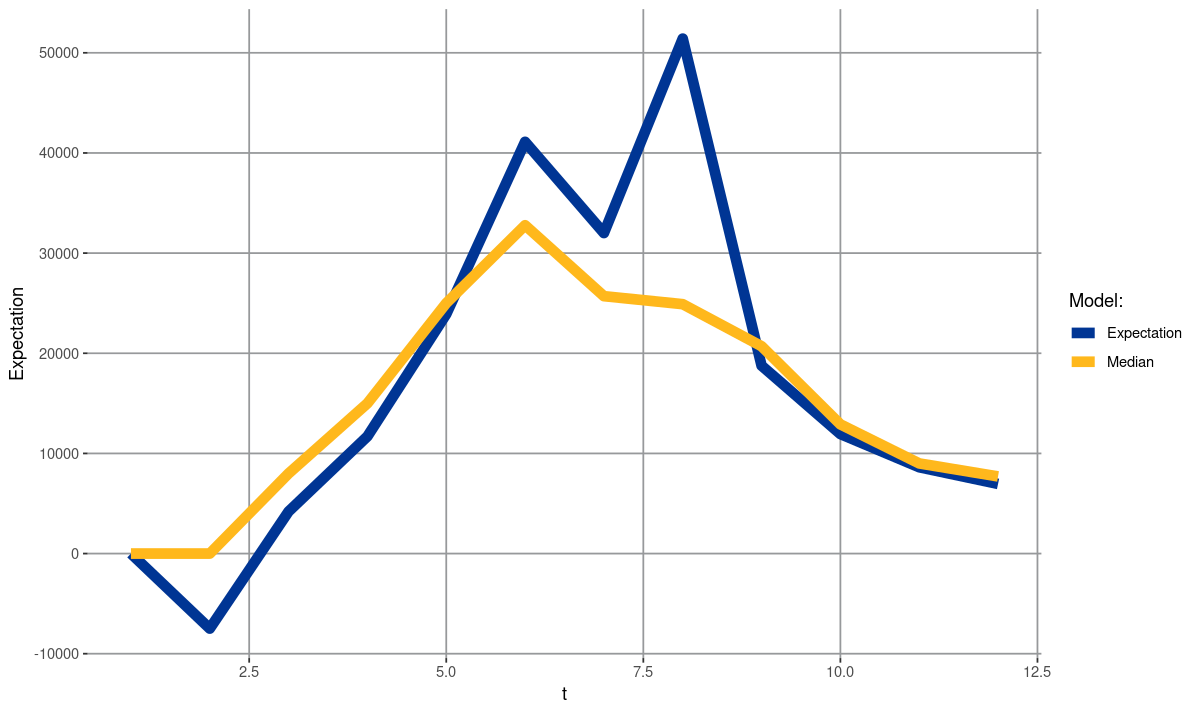

In [92]:
ggplot(data=pred.data)+geom_line(aes(x=t,y=Expectation,color="Expectation"),linewidth=3)+
geom_line(aes(x=t,y=Median,color="Median"),linewidth=3)+Pitt.Theme+ 
scale_color_manual(values = c('Expectation' = Pitt.Blue,'Median' = Pitt.Gold)) +labs(color = 'Model:')

## Check whether this is true for the top of the market too

In [94]:
q.model.bottom.decile<- rq(price~ y +m, data=valid.sales,tau=0.9)
summary(q.model.bottom.decile, se="iid")


Call: rq(formula = price ~ y + m, tau = 0.9, data = valid.sales)

tau: [1] 0.9

Coefficients:
              Value         Std. Error    t value       Pr(>|t|)     
(Intercept)    331900.00000   12396.80848      26.77302       0.00000
y2013          -27000.00000   11451.58867      -2.35775       0.01839
y2014            6000.00000   13080.56632       0.45870       0.64645
y2015           13670.00000   12709.01820       1.07561       0.28210
y2016            4500.00000   11875.33637       0.37894       0.70474
y2017           12500.00000   11834.28969       1.05625       0.29086
y2018           21000.00000   12152.26760       1.72807       0.08398
y2019           49500.00000   13318.12369       3.71674       0.00020
y2020           93000.00000   11291.35088       8.23639       0.00000
y2021          130000.00000   11197.52933      11.60970       0.00000
y2022          141000.00000   10986.43646      12.83401       0.00000
y2023          173100.00000   11093.46988      15.60377       0.0

In [ ]:
q.model.top.decile<- rq(price~ y +m, data=valid.sales,tau=0.90)
summary(q.model.top.decile, se="iid")

In [ ]:
summary(rq(price~ y +high.summer , data=valid.sales,tau=0.99), se="iid")
pred.data["Top.Decile"]<-predict(object = q.model.top.decile,newdata=pred.data)-331900-49500

In [ ]:
ggplot(data=pred.data)+geom_line(aes(x=t,y=Expectation,color="Expectation"),linewidth=3)+geom_line(aes(x=t,y=Median,color="Median"),linewidth=3)+geom_line(aes(x=t,y=Top.Decile,color="Top Decile"),linewidth=3)+
Pitt.Theme+ scale_color_manual(values = c('Expectation' = Pitt.Blue,'Median' = Pitt.Gold,"Top Decile"="red")) +labs(color = 'Model:')

From looking at this, I'd certainly believe that trying to sell my house in the summer made sense (though I should likely account for a month's lag to the closing dates listed here)

Less certain about the specific month effects, especially for the higher value houses.

### Interpretation Issues

There are some issues with quantile regression to do with how we can *interpret* the resulting effects. So what we were looking at before was the median house prices conditional on being sold in each of these months. However, it's not necessasily a causal story that if we just change the month we sell in, we should expect this gain. It could be that the houses that come up for sale in these months are just different in some other aspect.

More generally, we should be cautious because when we conduct quantile regressions we are modelling the conditional quantile across the data, where we can't directly think of the estimated effects in the same way as OLS.

That is, we might be interested in understanding how the median person's wage respond if we were to change that median person's education:
$$\frac{\partial\text{Median}(\text{wage})}{\partial\text{Educ}}=\beta_1$$

But instead, a quntile regression of wage on education tells us how the conditional-median changes as we look across different levels of education. That is, for a quantile-regression with $\tau=0.5$ we have the interpretation:
$$\beta_1 = \frac{\partial\text{Median}(\text{wage}|\text{Educ} ) }{\partial \text{Educ} } $$


More concretely, if education as measure in year, the model would tells us that the median wage among those with a college degree is $4\beta_1$ greater than the median wage for those with high school education.

Note that this *does not* tell us how the marginal effect of the variable for the overall median person, and how they would be affected by an additional year of education. 

This is different from standard regression, where the *law of iterated expectations* means that taking expectations over conditional expectations givesthe same overall expected effect 
$$ \mathbb{E}\left[ \mathbb{E}Y|X\right]=\mathbb{E}Y$$
And so we can interpret a slope $\beta$ as the unconditional effect for the average person too

## To show a quick example let's look at a quick simulation

In [ ]:
library(tidyverse)

In [ ]:
library(stats)
rndType<-runif(1001)
rndWealth.0<-5*rlnorm(1001, meanlog=10)
rndWealth.1<-10000*rchisq(1001,df=30)+10*rlnorm(1001, meanlog=10)
rndType<-ifelse(rndType<=0.75,0,1)
rndWealth<- ifelse(rndType==1,rndWealth.1,rndWealth.0)
df.example<-data.frame(wealth=rndWealth,coll.degree=factor(rndType))
head(df.example)

In [ ]:
ggplot(data=df.example, aes(x=wealth,color=coll.degree,alpha=0.9,y=after_stat(density)) ) +geom_histogram(fill="white",size=2,alpha=0.3,binwidth = 100000)+scale_color_manual(values=c(Pitt.Blue,Pitt.Gold))+Pitt.Theme+xlim(0,5000000)

In [ ]:
#or as a violin plot
ggplot(data=df.example, aes(x=as.factor(coll.degree), y=wealth,color=as.factor(coll.degree)) ,alpha=0.9) +
geom_violin(fill=Pitt.Gray,size=3)+scale_color_manual(values=c(Pitt.Blue,Pitt.Gold))+Pitt.Theme+ coord_flip()

## Linear Model
This reurns the average

In [ ]:
coef(lm(wealth~coll.degree,data=df.example))

So a college degree increases wealth by half a million dollars in this entirely made up data set

### Running the quantile regression here:

In [ ]:
wealth.median <- rq(wealth~ coll.degree , d=df.example, tau=0.5)
summary(wealth.median) 

In [ ]:
median( df.example$wealth )
median( subset(df.example,coll.degree==0)$wealth )
median( subset(df.example,coll.degree==1)$wealth )- median( subset(df.example,coll.degree==0)$wealth )

But what would be the effect on a median person, if we wanted to increase the likelihood of their attending college by a small increment?

### Unconditional effects
I won't go into the details here of how this package connects up the expected effects over the conditional medians, but there are some packages that do this. Unfortunately the below package no longer works!!


Returning to our house price data, the original model for the median told us that

So the median for houses sold in the summer months was \$13,000 higher than for the median for houses not sold in the summer.

But this model will hopefully tell us the effect for the median house sold in summer or not...

So quite a bit lower at a \$5,500 gain, suggesting that certainly something is different about the houses sold in other months